In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 데이터 로드 & 필터링
df = pd.read_csv('/vast/AI_team/gshwang/code/250429_attinduc_anno_test/notebooks/JofPATH/250519_experiments.csv')
df = df[
    (df['dataset'] == 'camelyon') &
    (df['sampling_ratio'] == 1) &
    (df['morphology_value'] == 0) &
    (df['model'].isin(['abmil', 'rank'])) &
    (df['random_state'].between(2018, 2027))
]

# 2) 모델 이름 매핑
df['Model'] = df['model'].map({
    'abmil': 'AB-MIL',
    'rank':  'Rank Induction'
})

# 3) AB-MIL 은 anno_ratio=0 으로 처리
df.loc[df['Model']=='AB-MIL', 'anno_ratio'] = 0.0

# 4) melt: AUROC/AUPRC long 포맷
df_long = df.melt(
    id_vars=['Model','anno_ratio'], 
    value_vars=['auroc','auprc'], 
    var_name='Metric', 
    value_name='Metric Value'
)
df_long['Metric'] = df_long['Metric'].map({'auroc':'AUROC','auprc':'AUPRC'})

# 5) x축 순서 (0부터 시작)
anno_order = sorted(df_long['anno_ratio'].unique())



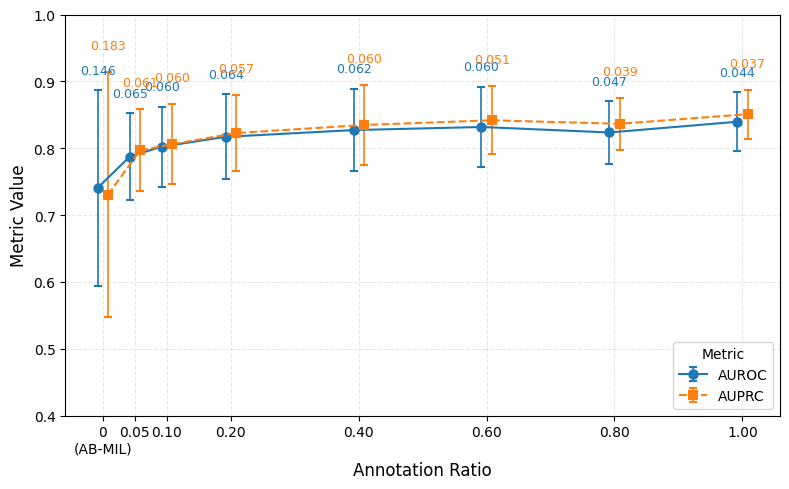

In [11]:
stats = (
    df_long
    .groupby(['anno_ratio','Metric'])['Metric Value']
    .agg(['mean','std'])
    .reset_index()
)

# 3) x축 순서
anno_order = sorted(stats['anno_ratio'].unique())

# 4) 스타일 설정
linestyles = {'AUROC':'solid', 'AUPRC':'dashed'}
markers    = {'AUROC':'o',      'AUPRC':'s'}
colors     = {'AUROC':'tab:blue','AUPRC':'tab:orange'}
offset     = 0.008  # x축 오프셋

plt.figure(figsize=(8,5))

for metric in ['AUROC','AUPRC']:
    sub = stats[stats['Metric']==metric].set_index('anno_ratio').loc[anno_order].reset_index()
    x    = np.array(sub['anno_ratio'])
    y    = sub['mean']
    err  = sub['std']
    
    # AUROC은 왼쪽, AUPRC는 오른쪽으로 약간 이동
    x_plot = x + ( -offset if metric=='AUROC' else +offset )
    
    plt.errorbar(
        x_plot, y,
        yerr=err,
        label=metric,
        marker=markers[metric],
        linestyle=linestyles[metric],
        color=colors[metric],
        capsize=3,
        elinewidth=1.2,
        markeredgewidth=1.5,
        markersize=6
    )
    # → 표준편차 값을 각 점 위에 표시
    if metric == "AUROC":
        add = 0.02
    else:
        add = 0.03
    for i in range(len(x)):
        plt.text(
            x_plot[i], y[i] + err[i]+add,                 # y[i] + 여백
            f"{err[i]:.3f}", 
            ha='center', va='bottom',
            fontsize=9, color=colors[metric]
        )

# 5) xticks 레이블 커스터마이징
labels = [
    "0\n(AB-MIL)" if x == 0.0 else f"{x:.2f}"
    for x in anno_order
]
plt.xticks(anno_order, labels)

plt.ylim(0.4, 1.0)
plt.xlabel('Annotation Ratio', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.legend(title='Metric', loc='lower right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

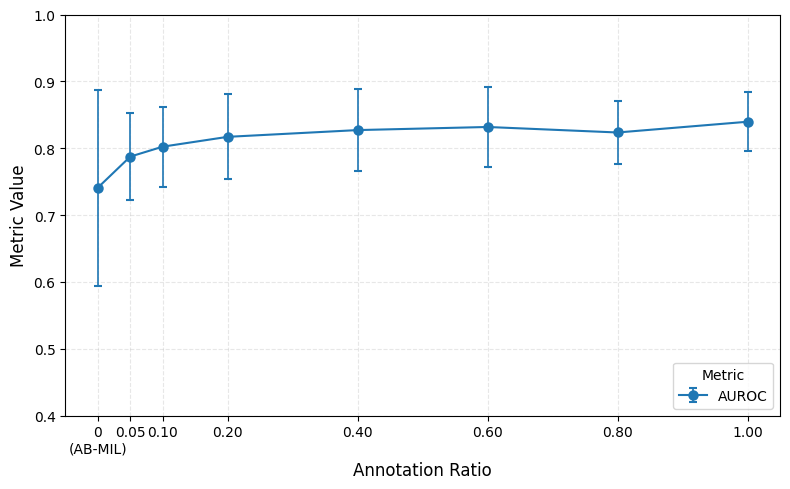

In [3]:
stats = (
    df_long
    .groupby(['anno_ratio','Metric'])['Metric Value']
    .agg(['mean','std'])
    .reset_index()
)

# 3) x축 순서
anno_order = sorted(stats['anno_ratio'].unique())

# 4) 스타일 설정
linestyles = {'AUROC':'solid', 'AUPRC':'dashed'}
markers    = {'AUROC':'o',      'AUPRC':'s'}
colors     = {'AUROC':'tab:blue','AUPRC':'tab:orange'}
offset     = 0.008  # x축 오프셋

plt.figure(figsize=(8,5))

for metric in ['AUROC']:
    sub = stats[stats['Metric']==metric].set_index('anno_ratio').loc[anno_order].reset_index()
    x    = np.array(sub['anno_ratio'])
    y    = sub['mean']
    err  = sub['std']
    
    plt.errorbar(
        x, y,
        yerr=err,
        label=metric,
        marker=markers[metric],
        linestyle=linestyles[metric],
        color=colors[metric],
        capsize=3,
        elinewidth=1.2,
        markeredgewidth=1.5,
        markersize=6
    )

# 5) xticks 레이블 커스터마이징
labels = [
    "0\n(AB-MIL)" if x == 0.0 else f"{x:.2f}"
    for x in anno_order
]
plt.xticks(anno_order, labels)

plt.ylim(0.4, 1.0)
plt.xlabel('Annotation Ratio', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.legend(title='Metric', loc='lower right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd

# 1) CSV 로드 & 필터링 (sampling_ratio=1, morphology_value=0, random_state 2018–2027)
df = pd.read_csv('/vast/AI_team/gshwang/code/250429_attinduc_anno_test/notebooks/JofPATH/250519_experiments.csv')
df = df[
    (df['dataset'] == 'camelyon') &
    (df['sampling_ratio'] == 1) &
    (df['morphology_value'] == 0) &
    (df['model'].isin(['abmil','rank'])) &
    (df['random_state'].between(2018, 2027))
]

# 2) AB-MIL → anno_ratio = 0.0 로 설정
df_ab = df[df['model']=='abmil'].copy()
df_ab['anno_ratio'] = 0.0

# 3) Rank Induction 은 그대로
df_rank = df[df['model']=='rank'].copy()

# 4) 두 데이터 합치기
df2 = pd.concat([df_ab, df_rank], ignore_index=True)

# 5) 그룹별 mean & std 계산
metrics = ['auroc','auprc','accuracy']
summary = (
    df2
    .groupby('anno_ratio')[metrics]
    .agg(['mean','std'])
    .round(3)
)

# 6) 원하는 순서대로 인덱스 재배치
order = [0.0, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
summary = summary.reindex(order)

# 7) “mean ± std” 형식으로 포맷팅
#    결과를 보기 편하게 새로운 DataFrame 으로 정리
formatted = pd.DataFrame(index=summary.index)
for metric in metrics:
    means = summary[(metric,'mean')].map('{:.3f}'.format)
    stds  = summary[(metric,'std')].map('{:.3f}'.format)
    formatted[metric] = means + ' ± ' + stds

# 8) 출력
formatted.index.name = 'annotation_ratio'
print(formatted)


                          auroc          auprc       accuracy
annotation_ratio                                             
0.00              0.741 ± 0.146  0.730 ± 0.183  0.778 ± 0.093
0.05              0.787 ± 0.065  0.797 ± 0.061  0.807 ± 0.041
0.10              0.802 ± 0.060  0.806 ± 0.060  0.806 ± 0.043
0.20              0.817 ± 0.064  0.823 ± 0.057  0.819 ± 0.036
0.40              0.827 ± 0.062  0.835 ± 0.060  0.829 ± 0.054
0.60              0.832 ± 0.060  0.842 ± 0.051  0.831 ± 0.029
0.80              0.823 ± 0.047  0.836 ± 0.039  0.829 ± 0.031
1.00              0.840 ± 0.044  0.851 ± 0.037  0.842 ± 0.019
